In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv


In [2]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_data = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
train_data.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


<Axes: xlabel='score', ylabel='count'>

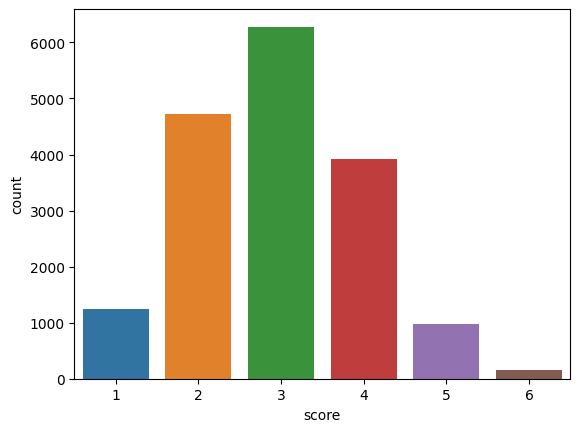

In [4]:
import seaborn as sns

sns.countplot(data=train_data, x='score')

In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+', '', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text

In [6]:
train_data['clean_text'] = train_data['full_text'].apply(preprocess_text)
train_data.head()

,essay_id,full_text,score,clean_text
0,000d118,Many people have car where they live. The thin...,3,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,3,scientist nasa discussing face mars explaining...
2,001ab80,People always wish they had the same technolog...,4,people always wish technology seen movies best...
3,001bdc0,"We all heard about Venus, the planet without a...",4,heard venus planet without almost oxygen earth...
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,dear state senator letter argue favor keeping ...


In [7]:
train_data_clean = train_data.drop(['full_text', 'essay_id'], axis='columns')
train_data_clean.head()

,score,clean_text
0,3,many people car live thing know use car alot t...
1,3,scientist nasa discussing face mars explaining...
2,4,people always wish technology seen movies best...
3,4,heard venus planet without almost oxygen earth...
4,3,dear state senator letter argue favor keeping ...


In [8]:
train_data_clean['score'] -= 1
train_data_clean.head()

,score,clean_text
0,2,many people car live thing know use car alot t...
1,2,scientist nasa discussing face mars explaining...
2,3,people always wish technology seen movies best...
3,3,heard venus planet without almost oxygen earth...
4,2,dear state senator letter argue favor keeping ...


In [9]:
max_length = max([len(x.split(' ')) for x in train_data_clean['clean_text']])
max_length

840

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense,Embedding, Dropout, GlobalAveragePooling1D, LSTM

2024-05-01 09:19:14.095415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 09:19:14.095547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 09:19:14.213585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
vectorizer = TextVectorization(max_tokens = 5000, output_mode='int', output_sequence_length=max_length)
vectorizer.adapt(train_data['clean_text'])

In [12]:
data_vectorized = vectorizer(train_data_clean['clean_text'])
data_vectorized = data_vectorized.numpy()
data_vectorized[0]

array([  12,    5,    4,  220,   76,   28,   43,    4,  268,   76,  173,
          8,   13,    1, 2751,    4,  144, 1754,   95,  381,  371,  542,
        118,    1, 1203,   84,  371,  898,    3, 1621,   84, 1109,    4,
        461,  796,    1, 1249,  275, 1423, 2227, 3307,    1,  469, 1861,
       3401, 2769, 2720,   34,    4,  371,  455,  400,    4,  203,  316,
        371, 4673,    4, 1908,  707,  172,  157, 1252,  466, 1423, 1727,
        471,    4, 1601, 2383,  242, 2717,  536,   15, 2333,  242,    4,
       1420,  699,  463,  275,  371,    5, 3045, 3272,   88,  106, 1393,
       1492,  286,    1,   21,  350, 1479,   45, 1788,   43,  231,  279,
       1501, 1158, 1580, 1707,  331,  372,  143,  345,    1,    1,    3,
        649,  787,   84,  372,  143,  345,  286,  847,   84,    4, 1521,
        169,   21,    1,   17,   38,   50,    1,  229,  303, 2905,   63,
        412,  371,  364, 1746, 1067,  798, 4149, 3297, 2320, 1304, 2915,
          1,    1,   88,  471,  136,   42,  394,  2

In [13]:
from tensorflow.keras.models import Sequential

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = Sequential()
# model.add(vectorizer)
model.add(Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True))
model.add(LSTM(units=256))
model.add(Dropout(0.1))
model.add(Dense(units=128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
from tensorflow.keras import layers
optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model = Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),output_dim=64))
model.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.GRU(units=64))
model.add(layers.Dense(units=6, activation='softmax'))

model.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
y_tf = tf.keras.utils.to_categorical(train_data_clean['score'], num_classes = 6)
y_tf = np.array(y_tf, dtype=int)

In [16]:
y_tf.shape

(17307, 6)

In [17]:
from sklearn.model_selection import train_test_split

dt_train, dt_test, lb_train, lb_test = train_test_split(data_vectorized, y_tf, test_size=0.2, random_state = 42)

In [20]:
model.fit(dt_train, lb_train, epochs = 10, validation_data=(dt_test, lb_test), batch_size = 8)

Epoch 1/10
 307/1731 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4720 - loss: 1.2128

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code

  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_34/2899396465.py", line 1, in <module>

  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 329, in fit

  File "/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 122, in one_step_on_iterator

Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.graph.launch' failed: CaptureGpuGraph failed (an unsupported value or parameter was passed to the function; current tracing scope: custom-call.6): INTERNAL: Failed to end stream capture: CUDA_ERROR_STREAM_CAPTURE_INVALIDATED: operation failed due to a previous error during capture; current profiling annotation: XlaModule:#hlo_module=a_inference_one_step_on_data_62627__.901,program_id=1015#.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_62686]

In [35]:
test_prediction = model.predict(dt_test)
test_prediction[0]

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([9.9274400e-10, 1.1521450e-05, 5.3002744e-04, 6.9879770e-01,
       3.0066073e-01, 3.8100385e-08], dtype=float32)

In [37]:
test_pre = np.argmax(test_prediction, axis = 1)
test_pre[:5]

array([3, 3, 2, 1, 2])

In [38]:
exp_label = np.argmax(lb_test, axis = 1)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(test_pre, exp_label))

              precision    recall  f1-score   support

           0       0.34      0.44      0.39       201
           1       0.59      0.57      0.58       990
           2       0.62      0.55      0.58      1424
           3       0.47      0.55      0.51       633
           4       0.46      0.42      0.44       200
           5       0.23      0.64      0.34        14

    accuracy                           0.54      3462
   macro avg       0.45      0.53      0.47      3462
weighted avg       0.56      0.54      0.55      3462



In [40]:
test_data = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
test_data.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [41]:
test_data['clean_text'] = test_data['full_text'].apply(preprocess_text)
test_data.head()

,essay_id,full_text,clean_text
0,000d118,Many people have car where they live. The thin...,many people car live thing know use car alot t...
1,000fe60,I am a scientist at NASA that is discussing th...,scientist nasa discussing face mars explaining...
2,001ab80,People always wish they had the same technolog...,people always wish technology seen movies best...


In [42]:
test_vectorized = vectorizer(test_data['clean_text'])

In [43]:
test_pre = model.predict(test_vectorized)
test_pre

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[2.0584669e-06, 3.0847706e-03, 9.9683845e-01, 7.4801923e-05,
        9.4848784e-14, 2.2313559e-20],
       [1.0249848e-06, 2.1409158e-02, 9.7858036e-01, 9.4189363e-06,
        3.4267642e-16, 4.3992160e-22],
       [3.0036185e-11, 4.5344689e-07, 6.1043829e-04, 9.9755812e-01,
        1.8310084e-03, 5.3948396e-14]], dtype=float32)

In [44]:
test_predictions = np.argmax(test_pre, axis = 1)
test_predictions

array([2, 2, 3])

In [45]:
results = pd.DataFrame({'essay_id': test_data['essay_id'], 'score': test_predictions})
results.head()

,essay_id,score
0,000d118,2
1,000fe60,2
2,001ab80,3


In [46]:
results.to_csv('submission.csv', index=False)